In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import math

from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from common.utils import  mape

In [62]:
df = pd.read_csv('data/Electric_Production.csv')
print(df.shape)

(397, 2)


In [63]:
df.rename(columns={'IPG2211A2N':'Production'},inplace = True)

In [64]:
df.set_index('DATE',inplace = True)

In [65]:
df.head()

,Production
DATE,
1/1/1985,72.5052
2/1/1985,70.6720
3/1/1985,62.4502
4/1/1985,57.4714
5/1/1985,55.3151


In [66]:
df.index = pd.to_datetime(df.index)

In [67]:
train_series = df.loc[:'2013','Production']
test_series = df.loc['2014':'2017','Production']

In [68]:
print(len(train_series))
print(len(test_series))

348
48


In [69]:
train_df = train_series.to_frame(name='train')
test_df = test_series.to_frame('test')

In [70]:
sns.set(rc={'figure.figsize':(11, 4)})

<AxesSubplot:xlabel='DATE'>

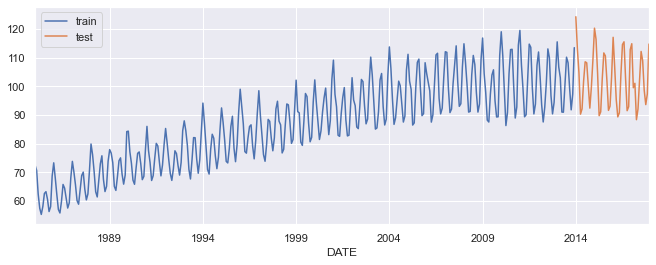

In [71]:
train_df.join(test_df,how='outer').plot()

In [72]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_df.rename(columns = {'train':'Production'},inplace = True)
train_df['Production'] = scaler.fit_transform(train_df)
train_df.head(10)

,Production
DATE,
1985-01-01,0.267872
1985-02-01,0.239305
1985-03-01,0.111186
1985-04-01,0.033601
1985-05-01,0.000000
1985-06-01,0.043247
1985-07-01,0.113835
1985-08-01,0.123625
1985-09-01,0.082114


In [73]:
test_df.rename(columns = {'test':'Production'},inplace = True)
test_df['Production'] = scaler.transform(test_df)
test_df.head()

,Production
DATE,
2014-01-01,1.074282
2014-02-01,0.897045
2014-03-01,0.770543
2014-04-01,0.544959
2014-05-01,0.573745


In [74]:
# Converting to numpy arrays
train_data = train_df.values
test_data = test_df.values

In [75]:
timesteps=5

In [76]:
train_data_timesteps=np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(344, 5)

In [77]:
#the first four columns are the inputs and the last column is the ouput, just like every regression problems are
train_data_timesteps[:5]

array([[0.26787164, 0.23930506, 0.11118556, 0.03360141, 0.        ],
       [0.23930506, 0.11118556, 0.03360141, 0.        , 0.04324723],
       [0.11118556, 0.03360141, 0.        , 0.04324723, 0.11383466],
       [0.03360141, 0.        , 0.04324723, 0.11383466, 0.12362539],
       [0.        , 0.04324723, 0.11383466, 0.12362539, 0.0821141 ]])

In [78]:
test_data_timesteps=np.array([[j for j in test_data[i:i+timesteps]] for i in range(0,len(test_data)-timesteps+1)])[:,:,0]
test_data_timesteps.shape

(44, 5)

In [79]:
x_train, y_train = train_data_timesteps[:,:timesteps-1],train_data_timesteps[:,[timesteps-1]]
x_test, y_test = test_data_timesteps[:,:timesteps-1],test_data_timesteps[:,[timesteps-1]]

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(344, 4) (344, 1)
(44, 4) (44, 1)


In [80]:
model = SVR(kernel='rbf',gamma=0.5, C=10, epsilon = 0.05)

In [81]:
model.fit(x_train, y_train[:,0])

SVR(C=10, epsilon=0.05, gamma=0.5)

In [82]:
y_train_pred = model.predict(x_train).reshape(-1,1)
y_test_pred = model.predict(x_test).reshape(-1,1)

print(y_train_pred.shape, y_test_pred.shape)

(344, 1) (44, 1)


In [83]:
# Scaling the predictions
y_train_pred = scaler.inverse_transform(y_train_pred)
y_test_pred = scaler.inverse_transform(y_test_pred)

print(len(y_train_pred), len(y_test_pred))

344 44


In [84]:
# Scaling the original values
y_train = scaler.inverse_transform(y_train)
y_test = scaler.inverse_transform(y_test)

print(len(y_train), len(y_test))

344 44


In [85]:
train_timestamps = df.loc[:'2013','Production'].index[timesteps-1:]
test_timestamps = df.loc['2014':'2017','Production'].index[timesteps-1:]
print(len(train_timestamps), len(test_timestamps))

344 44


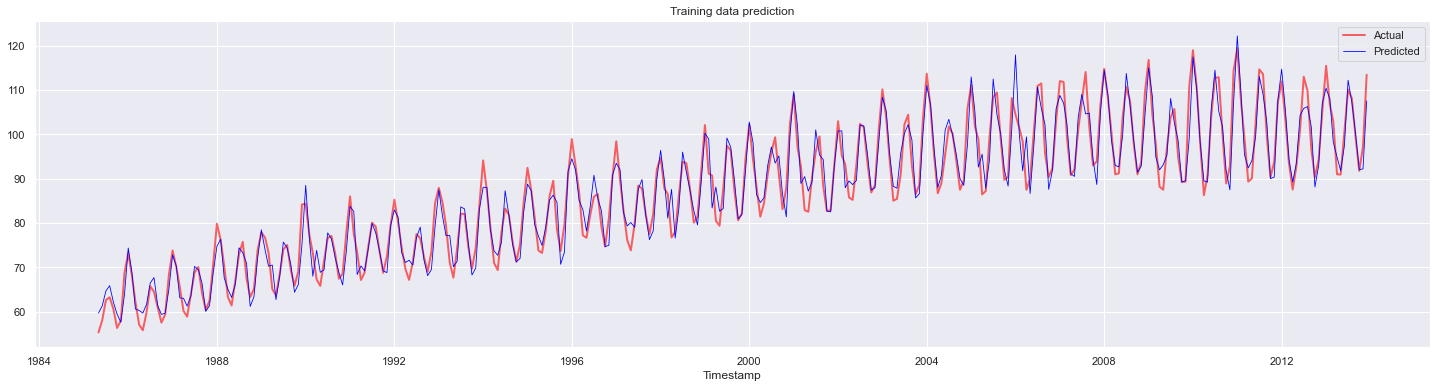

In [86]:
plt.figure(figsize=(25,6))
plt.plot(train_timestamps, y_train, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(train_timestamps, y_train_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.title("Training data prediction")
plt.show()

In [87]:
#the evaluating metric used here is mean absolute percentage error
print('MAPE for training data: ', mape(y_train_pred, y_train)*100, '%')

MAPE for training data:  3.116374011184455 %


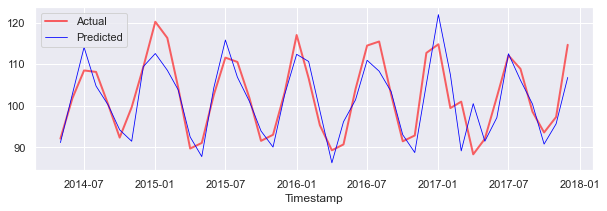

In [88]:
plt.figure(figsize=(10,3))
plt.plot(test_timestamps, y_test, color = 'red', linewidth=2.0, alpha = 0.6)
plt.plot(test_timestamps, y_test_pred, color = 'blue', linewidth=0.8)
plt.legend(['Actual','Predicted'])
plt.xlabel('Timestamp')
plt.show()

In [90]:
print('MAPE for testing data: ', mape(y_test_pred, y_test)*100, '%')

MAPE for testing data:  3.742609808163247 %
